# 1. Transformación de imágenes a formato estructurado

**Objetivo:** Extracción de rasgos globales de imágenes del dataset EuroSat


**Información de las características**
Este dataset contiene imágenes que pertenecen all dataset de EuroSat. Hay 10 folders:
* 0 AnnualCrop
* 1 Forest
* 2 HerbaceousVegatation
* 3 Highway
* 4 Industrial
* 5 Pasture
* 6 PermanentCrop
* 7 Residential
* 8 River
* 9 SeaLake


**Número de instancias:** 27000

# 1. Acceso a drive

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# 2. Importando librerías

In [2]:
pip install mahotas

     |████████████████████████████████| 5.7MB 1.9MB/s 


In [4]:
import shutil
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#from skimage.feature import hog
from skimage.io import imread
from skimage.transform import rescale
import mahotas
import cv2
import os
import random

# 3. Rutas de las imágenes y de resultados

---



Ruta donde se encuentran las subcarpetas de entrenamiento, validación y prueba

In [9]:
path_train = r'/content/drive/MyDrive/EuroSat/EuroSAT'

Ruta donde se guardarán los resultados

In [6]:
results_path = r'/content/drive/Shareddrives/Data Science para Geociencias/4. Selección de caracteristicas'

Tamaño de las imágenes

In [7]:
fixed_size = (64, 64)

In [13]:
folders = sorted([d for d in os.listdir(path_train) if os.path.isdir(os.path.join(path_train,d))])
print(folders)

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


# 4. Exploración de los datos

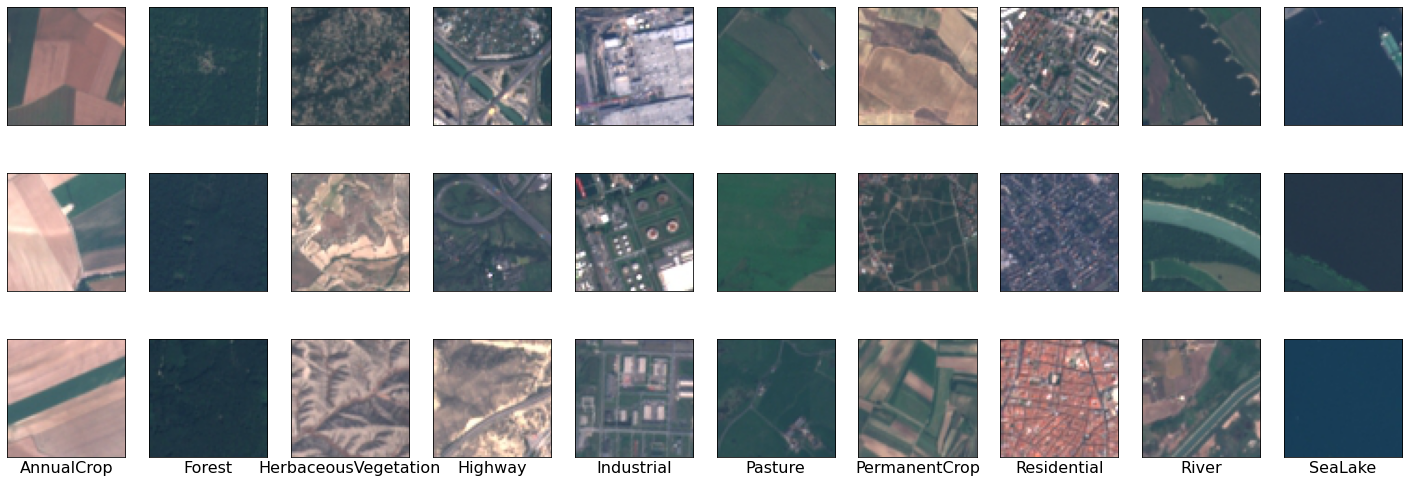

In [14]:
plt.figure(figsize=(25,30))
for i,folder in enumerate(folders):
    path_folder = os.path.join(path_train, folder)
    imgs_list =os.listdir(path_folder)
    random.shuffle(imgs_list)
    for j in range(3):
      img_path = os.path.join(path_folder,imgs_list[j])
      plt.subplot(10,10,j*10+i+1)
      img = plt.imread(img_path)
      plt.imshow(img)
      #plt.axis("off")
      plt.tick_params(axis='both',which='both', bottom=False, top=False, left=False, right=False,
                        labelbottom=False, labelleft=False)
      if j==2:
        plt.xlabel(folder,
        horizontalalignment='center',
        verticalalignment='top', fontsize=16)
      #plt.grid('on')
#plt.grid('off')
plt.show()

### Distribución de las clases

Funciones para contar el número de imágenes de cada clase y para plotear el histograma de distribución de clases

In [15]:
def count_labels(clases, path):
    n_img =[]
    for i, rock in enumerate(clases):
        pathi = os.path.join(path,rock)
        n_img.append(len(os.listdir(pathi)))
    #print(n_img)
    labels = []
    for i in range(len(clases)):
        labels.append([clases[i]]*n_img[i])
    ylabels = labels[0]
    for i in range(1,len(labels)):
        ylabels += labels[i]
    return ylabels, n_img

def histograma(ylabels, clases, title, color="goldenrod"):
    #histogramas de las categorias de las imágenes 
    plt.figure(figsize=(15,6))
    a = np.array(ylabels)
    plt.hist(a, bins=np.arange(-0.5,len(clases)+0.5,1.0), rwidth=0.7, color=color, ec=color)
    plt.title(title)
    plt.show()

Primero observamos la distribución de clases para el conjunto de entrenamiento

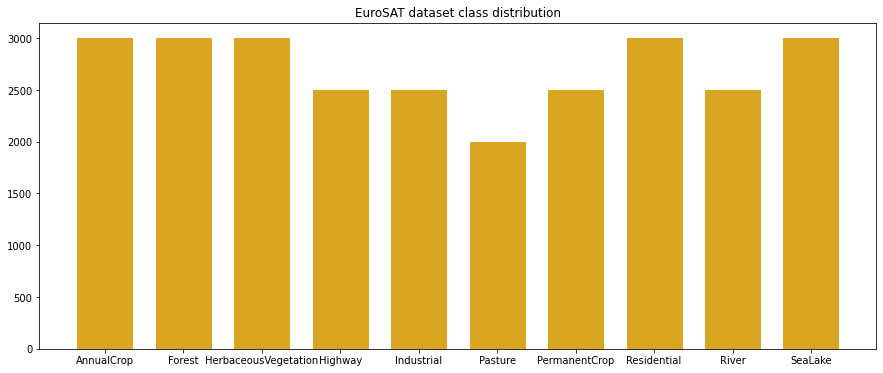

In [16]:
clases = folders 
ylabels, n_img = count_labels(folders, path_train)
histograma(ylabels, folders,"EuroSAT dataset class distribution")

¿Cuántas imágenes hay por conjunto?

In [18]:
ntrain = np.sum(n_img)
print("Hay %s imágenes en total"%ntrain)

Hay 27000 imágenes en total


# 5. Descriptores Globales

Los descriptores globales de una imagen son características de las imágenes, algunos describen contenido de color, textura, rotación, etc.

#### Momentos Hu

Un momento de imagen es cierto promedio ponderado particular de las intensidades de los píxeles de una imagen. Se obtienen 7 momentos Hu.

In [19]:
# descriptor de rasgos: Momentos Hu 
def fd_hu_moments(image):
  # convertir imagen en escala de grises
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  # calculo del vector de rasgos de momentos Hu
  feature = cv2.HuMoments(cv2.moments(image)).flatten()
  return feature

#### Textura Haralick

La textura nos facilita la representación de la “sensación”, apariencia e incluso la consistencia de una superficie en una imagen. En total son 13 columnas de características



In [20]:
# descriptor de rasgos: Haralick Texture
def fd_haralick(image):
  # convertir imagen en escala de grises
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  # calculo del vector de rasgos de textura haralick
  haralick = mahotas.features.haralick(gray).mean(axis=0)
  return haralick

#### Histograma de color

Los descriptores de histograma de color se calcular separando el color en 3 espacios: RGB, HLS y CIE. Cada dimensión se cuantifica en 8 bin para obtener una longitud de 512 características. 

In [21]:
# descriptor de rasgos: Histograma de color
def fd_histogram(image, mask=None, bins=8):
  # conversión de la imagen al espacio de color HSV
  image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
  # calculo del histograma de color
  hist  = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
  # normalización del histograma
  cv2.normalize(hist, hist)
  return hist.flatten()

# 6. Extracción de descriptores globales por imagen

Creando los dataframes para entrenamiento, validación y prueba

In [31]:
ind_train=[]

hist = ["color_%s"%i for i in range(512)]
hal = ["texture_%s"%i for i in range(13)]
hum = ["Hu_%s"%i for i in range(7)]

cols = hist + hal+ hum + ['label']
ind_train = [i for i in range(ntrain)]
train_df = pd.DataFrame(columns = cols, index=ind_train) 
print(train_df.shape)

(27000, 533)


Enlistando las clases 

In [32]:
train_labels = clases
print(train_labels)

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


Realizando la extracción de rasgos globales para el conjunto de entrenamiento

In [ ]:
ac=0
# ciclo sobre los folders
for training_name in train_labels:
    # directorio de la clase
    dirc = os.path.join(path_train, training_name)
    # nombre de la clase actual
    current_label = training_name
    images = os.listdir(dirc)
    images.sort()
    # ciclo sobre cada imagen
    for image_name in images:
        # path de la imagen
        file = os.path.join(dirc,image_name)
        # lectura y redimensionar la imagen
        image = cv2.imread(file)
        image = cv2.resize(image, fixed_size)
        # Extraccion de rasgos globales
        fv_hu_moments = fd_hu_moments(image)
        fv_haralick   = fd_haralick(image)
        fv_histogram  = fd_histogram(image)
        # Concatenacion de rasgos
        linea = np.hstack([fv_histogram, fv_haralick, fv_hu_moments, current_label])
        # agrega linea al dataframe vacío 
        train_df.iloc[ac] = linea
        ac+=1
    print("Folder procesado: {}".format(current_label))

print("Extracción de rasgos globales completa")

Guardando el dataframe a un .csv

In [ ]:
train_df.to_csv(os.path.join(results_path,'EUROSAT_TRAIN_FEAT.csv'), index=False)